# Assignment 2 - Convolutional Neural Network

## Data processing
First of all, the data sets needs to be processed before feeded into the model training process. Therefore, the provided `load_dataset()` function handles it. Going further with the `ImageFolder` created from `load_dataset`, one can prepare it as `DataLoader` type to easen up the training, validation, and testing process as follows

In [1]:
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
from torch.utils.data import ConcatDataset
from sklearn.model_selection import KFold


def load_dataset(train_path=r"WF-data/train", test_path=r"WF-data/test"):

    transform = transforms.Compose([transforms.Resize([105, 78]),
                                    transforms.CenterCrop(size=[60, 30]),
                                    transforms.ToTensor()])
    # target_transform = {"ng": 0, "ok": 1}

    train_dataset = datasets.ImageFolder(train_path, transform=transform, target_transform=None)
    test_dataset = datasets.ImageFolder(test_path, transform=transform, target_transform=None)

    return train_dataset, test_dataset


# Creating the data set
train_dataset, test_dataset = load_dataset()
print(f"Datapoints for training is {len(train_dataset)} and for test is {len(test_dataset)}")

# Preparing the K-fold
data_set = ConcatDataset([train_dataset, test_dataset]) # Concatenating it for the K-fold

kfold = KFold(n_splits=5, shuffle=True)

# Create data loaders
# batch_size = 5
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Datapoints for training is 136 and for test is 34


To display a sample of the data set, one can use the `ImageFolder` and permute it to get the RGB colour-spectrum.

torch.Size([3, 60, 30])


(-0.5, 29.5, 59.5, -0.5)

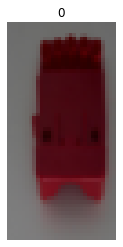

In [2]:
from numpy import random

random_image = random.choice(len(data_set))

img, labels = data_set[random_image][0], data_set[random_image][1]
# print(img.size)
# # Display the image
# img.show()
print(img.shape)
plt.imshow(img.permute(1,2,0)) # Permutation is used to display the image in RGB instead of gray colormap
plt.title(labels)
plt.axis(False)

## The Model

This Convolutional Neural Network is based on the VGG architecture, which is a good model architecture for detail recognition. To implement it, we can use the [CNN Calculator](https://thanos.charisoudis.gr/blog/a-simple-conv2d-dimensions-calculator-logger) to build the architecture.

In [3]:
import torch.nn as nn
import torch.nn.init as init
import torch

class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5, num_neurons_fc1=1024, num_neurons_fc2=128):
        super(ConvNeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc1 = nn.Sequential(nn.Dropout(dropout_rate), nn.Linear(7*15*128, num_neurons_fc1), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Dropout(dropout_rate), nn.Linear(num_neurons_fc1, num_neurons_fc2), nn.ReLU())
        self.dense = nn.Linear(num_neurons_fc2, num_classes)
        
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
    

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return self.dense(out)


## Training code (K-folds)

In this part, we defined the training of the CNN model. Furthermore, we are specifying it for 30 epochs.

In [4]:
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import SubsetRandomSampler, DataLoader
from torch.backends import mps
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau


def training_Kfold(model, num_epochs, data_set, kfold, criterion, optimizer, batch_size, patience=5, save_model=True, savepath="CNN_model.pth"):
    """
    Training function
    -----------------
    Input:
        model: PyTorch model
        num_epochs: Number of maximum epochs
        train_loader: DataLoader type dataset for training
        test_loader: DataLoader type dataset for validation
        criterion: Loss function
        optimizer: Optimizer function for the training
        early_stopping: EarlyStopping functionality 
        save_model: If True, then it saves the model parameters
    Output:
        model: Trained PyTorch model
        training_log: Data of the training results for further use
    """
    
    def reset_weights(m):
        '''
        Try resetting model weights to avoid weight leakage.
        '''
        for layer in m.children():
            if hasattr(layer, 'reset_parameters'):
                # print(f'Reset trainable parameters of layer = {layer}')
                layer.reset_parameters()

    # scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=6, factor=0.1, verbose=True)

    torch.manual_seed(42) # Set fixed random number seed for reproducibility
    dev = torch.device('mps' if mps.is_available() else 'cpu') # GPU support for PyTorch in MacOS
    # dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'

    print(f"Device: {dev}, GPU: {(dev)}")

    train_log = {'loss': []}
    fold_log = {'acc': []}

    best_loss = float('inf')  # Initialize with a high value

    for fold, (train_ids, test_ids) in enumerate(kfold.split(data_set)):
        # epochs_without_improvement = 0
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_scores = []
        train_losses = []
        valid_scores = []
        valid_losses = []
        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = SubsetRandomSampler(train_ids)
        test_subsampler = SubsetRandomSampler(test_ids)
    
        # Define data loaders for training and testing data in this fold
        train_loader = DataLoader(data_set, batch_size=batch_size, sampler=train_subsampler)
        test_loader = DataLoader(data_set, batch_size=batch_size, sampler=test_subsampler)

        model.apply(reset_weights)
        model.to(dev)
        train_correct, train_loss, train_accuracy, train_count = 0.0, 0.0, 0.0, 0.0
        valid_correct, valid_loss, valid_accuracy, valid_total = 0.0, 0.0, 0.0, 0.0
        train_batch_losses = []
        for epoch in range(num_epochs):
            current_train_loss = 0.0
            current_valid_loss = 0.0
            # train_correct, train_count = 0.0, 0.0

            for _, (images, labels) in enumerate(train_loader):
                
                images = images.to(dev)
                labels = labels.to(dev)

                optimizer.zero_grad() # Zero out the gradients for initialisation
                outputs = model(images) # Compute output for Forward pass
                loss = criterion(outputs, labels) # Compute loss
                loss.backward() # Perform backpropagation step
                optimizer.step() # Update the weights

                current_train_loss += loss.item()
                train_batch_losses.append(loss.item())
                _, predicted = torch.max(outputs.data, 1)
                train_correct += (predicted == labels).sum().item()
                train_count += labels.size(0) 

            current_train_loss /= len(train_loader)
            current_train_accuracy = train_correct / train_count
            train_loss += current_train_loss
            train_accuracy += current_train_accuracy
        
            train_losses.append(current_train_loss)
            train_scores.append(current_train_accuracy)

            # Validation Process
            with torch.no_grad():
                for _, (images, labels) in enumerate(test_loader):
                    images, labels = images.to(dev), labels.to(dev)
                    outputs = model(images)

                    _, predicted = torch.max(outputs.data, 1)
                    valid_correct += (predicted == labels).sum().item()
                    valid_total += labels.size(0)
                    loss = criterion(outputs, labels)
                    current_valid_loss += loss.item()

            current_valid_loss /= len(test_loader)
            valid_accuracy = valid_correct / valid_total

            valid_losses.append(current_valid_loss)
            valid_scores.append(valid_accuracy)
            print(f"Epoch {epoch+1}: Training loss = {current_train_loss:.3f}, Validation loss = {current_valid_loss:.3f}")

            # # Update learning rate
            # scheduler.step(current_valid_loss)

            # # Check if validation loss has improved
            # if current_valid_loss < best_loss:
            #     best_loss = current_valid_loss
            #     epochs_without_improvement = 0
            # else:
            #     epochs_without_improvement += 1

            # # Check if early stopping condition is met
            # if epochs_without_improvement >= patience:
            #     print("Early stopping! No improvement for", patience, "epochs.")
            #     break
            
             
        print('Finished training \n')
        if save_model: torch.save(model.state_dict(), savepath) 
        
        # Plot loss and score curves for this fold
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_batch_losses, label='Training Loss (Batch)')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title('Loss Curve (Fold {})'.format(fold+1))
        plt.legend()
        
        # Plot loss and score curves for this fold
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(valid_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve (Fold {})'.format(fold+1))
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_scores, label='Training Score')
        plt.plot(valid_scores, label='Validation Score')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title('Score Curve (Fold {})'.format(fold+1))
        plt.legend()

        plt.tight_layout()
        plt.show()      

    # Printing and saving the metrics for later use
    print(f'Accuracy for fold {fold+1} = {100*valid_correct / valid_total:.3f}%\n')
    train_log['loss'].append(train_loss/num_epochs)
    fold_log['acc'].append(valid_correct/valid_total)

    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {fold+1} FOLDS')
    print('----------------------------------------------------')
    print(f"Average Accuracy = {np.mean(fold_log['acc'])*100:.2f}%")

    return model.to("cpu"), train_log, fold_log

def test(trained_model, test_dataset, batch_size=5):
    """
    Testing the trained model with K-fold
    """
    test_loader = DataLoader(test_dataset, batch_size, shuffle=True)
    trained_model.eval()  # Switch model to evaluation mode
    with torch.no_grad():
        test_correct, test_total = 0.0, 0.0
        for _, (images, labels) in enumerate(test_loader):
            outputs = trained_model(images)

            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
        
        test_acc = test_correct/test_total
    print(f"Test accuracy = {test_acc*100:.2f}%")

## Train and evaluate model with initial hyperparameters

The following hyperparameters were used:
|Parameter |Value  |
--- | --- |
|lr|0.001|
|Optimizer|Adam|
|wd|default: 0|
|epochs|30|
|natch size|8|
|FC1|1024|
|FC2|128|


Device: mps, GPU: mps
FOLD 1
--------------------------------
Epoch 1: Training loss = 1.503, Validation loss = 0.710
Epoch 2: Training loss = 0.730, Validation loss = 0.709
Epoch 3: Training loss = 0.679, Validation loss = 0.682
Epoch 4: Training loss = 0.682, Validation loss = 0.534
Epoch 5: Training loss = 0.521, Validation loss = 0.346
Epoch 6: Training loss = 0.363, Validation loss = 0.317
Epoch 7: Training loss = 0.407, Validation loss = 0.229
Epoch 8: Training loss = 0.199, Validation loss = 0.217
Epoch 9: Training loss = 0.298, Validation loss = 0.202
Epoch 10: Training loss = 0.310, Validation loss = 0.160
Epoch 11: Training loss = 0.301, Validation loss = 0.115
Epoch 12: Training loss = 0.256, Validation loss = 0.524
Epoch 13: Training loss = 0.356, Validation loss = 0.250
Epoch 14: Training loss = 0.249, Validation loss = 0.121
Epoch 15: Training loss = 0.216, Validation loss = 0.298
Epoch 16: Training loss = 0.144, Validation loss = 0.409
Epoch 17: Training loss = 0.097, Va

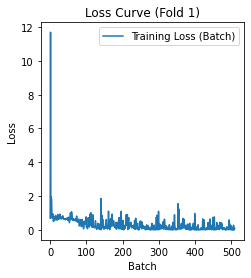

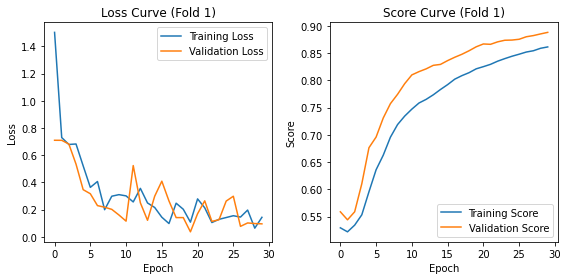

FOLD 2
--------------------------------
Epoch 1: Training loss = 2.505, Validation loss = 1.406
Epoch 2: Training loss = 0.862, Validation loss = 0.703
Epoch 3: Training loss = 0.708, Validation loss = 0.684
Epoch 4: Training loss = 0.690, Validation loss = 0.666
Epoch 5: Training loss = 0.686, Validation loss = 0.681
Epoch 6: Training loss = 0.684, Validation loss = 0.656
Epoch 7: Training loss = 0.656, Validation loss = 0.616
Epoch 8: Training loss = 0.620, Validation loss = 0.581
Epoch 9: Training loss = 0.695, Validation loss = 0.670
Epoch 10: Training loss = 0.705, Validation loss = 0.701
Epoch 11: Training loss = 0.607, Validation loss = 0.535
Epoch 12: Training loss = 0.497, Validation loss = 0.488
Epoch 13: Training loss = 0.379, Validation loss = 0.265
Epoch 14: Training loss = 0.323, Validation loss = 1.950
Epoch 15: Training loss = 0.589, Validation loss = 0.479
Epoch 16: Training loss = 0.341, Validation loss = 0.093
Epoch 17: Training loss = 0.577, Validation loss = 0.663


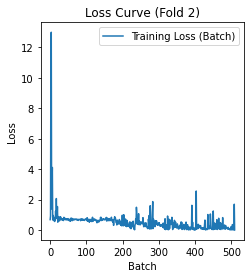

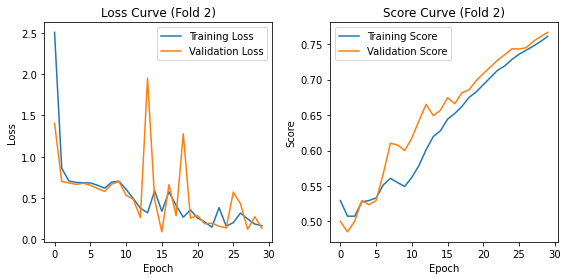

FOLD 3
--------------------------------
Epoch 1: Training loss = 2.565, Validation loss = 0.637
Epoch 2: Training loss = 0.807, Validation loss = 0.872
Epoch 3: Training loss = 0.696, Validation loss = 0.720
Epoch 4: Training loss = 0.636, Validation loss = 0.726
Epoch 5: Training loss = 0.631, Validation loss = 0.512
Epoch 6: Training loss = 0.559, Validation loss = 0.622
Epoch 7: Training loss = 0.504, Validation loss = 0.548
Epoch 8: Training loss = 0.457, Validation loss = 0.699
Epoch 9: Training loss = 0.460, Validation loss = 0.376
Epoch 10: Training loss = 0.427, Validation loss = 0.691
Epoch 11: Training loss = 0.425, Validation loss = 0.552
Epoch 12: Training loss = 0.318, Validation loss = 0.292
Epoch 13: Training loss = 0.218, Validation loss = 0.268
Epoch 14: Training loss = 0.329, Validation loss = 0.584
Epoch 15: Training loss = 0.317, Validation loss = 0.758
Epoch 16: Training loss = 0.307, Validation loss = 0.203
Epoch 17: Training loss = 0.328, Validation loss = 0.294


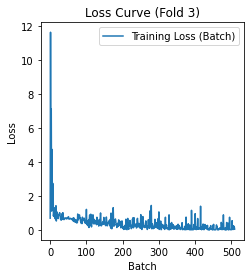

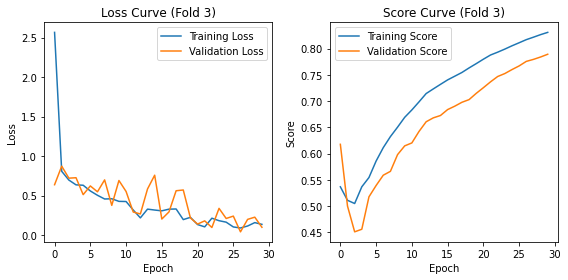

FOLD 4
--------------------------------
Epoch 1: Training loss = 2.111, Validation loss = 0.713
Epoch 2: Training loss = 0.707, Validation loss = 0.659
Epoch 3: Training loss = 0.698, Validation loss = 0.758
Epoch 4: Training loss = 0.696, Validation loss = 0.694
Epoch 5: Training loss = 0.693, Validation loss = 0.679
Epoch 6: Training loss = 0.661, Validation loss = 0.764
Epoch 7: Training loss = 0.698, Validation loss = 0.713
Epoch 8: Training loss = 0.617, Validation loss = 1.098
Epoch 9: Training loss = 0.551, Validation loss = 0.662
Epoch 10: Training loss = 0.451, Validation loss = 0.303
Epoch 11: Training loss = 0.273, Validation loss = 0.236
Epoch 12: Training loss = 0.252, Validation loss = 1.203
Epoch 13: Training loss = 0.304, Validation loss = 0.376
Epoch 14: Training loss = 0.203, Validation loss = 0.160
Epoch 15: Training loss = 0.372, Validation loss = 0.368
Epoch 16: Training loss = 0.316, Validation loss = 0.489
Epoch 17: Training loss = 0.200, Validation loss = 0.414


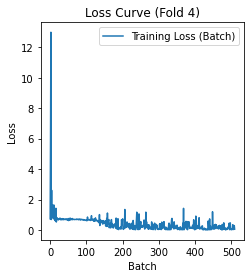

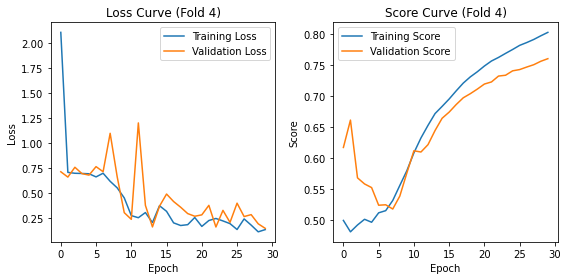

FOLD 5
--------------------------------
Epoch 1: Training loss = 2.374, Validation loss = 0.660
Epoch 2: Training loss = 0.819, Validation loss = 0.842
Epoch 3: Training loss = 0.748, Validation loss = 0.793
Epoch 4: Training loss = 0.673, Validation loss = 0.697
Epoch 5: Training loss = 0.619, Validation loss = 0.820
Epoch 6: Training loss = 0.560, Validation loss = 0.757
Epoch 7: Training loss = 0.388, Validation loss = 0.622
Epoch 8: Training loss = 0.586, Validation loss = 0.394
Epoch 9: Training loss = 0.253, Validation loss = 0.613
Epoch 10: Training loss = 0.271, Validation loss = 0.684
Epoch 11: Training loss = 0.382, Validation loss = 0.822
Epoch 12: Training loss = 0.383, Validation loss = 0.355
Epoch 13: Training loss = 0.312, Validation loss = 0.278
Epoch 14: Training loss = 0.229, Validation loss = 0.168
Epoch 15: Training loss = 0.260, Validation loss = 0.310
Epoch 16: Training loss = 0.219, Validation loss = 0.340
Epoch 17: Training loss = 0.256, Validation loss = 0.413


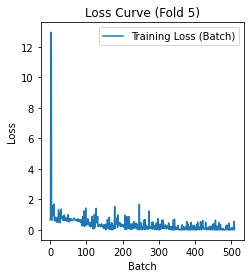

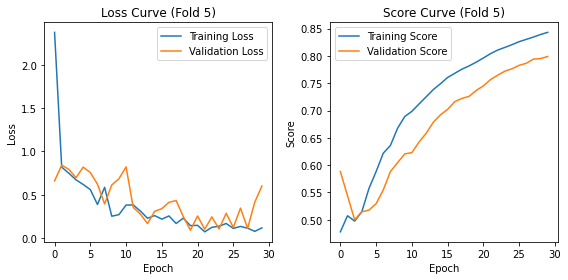

Accuracy for fold 5 = 79.902%

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
----------------------------------------------------
Average Accuracy = 79.90%
Test accuracy = 100.00%


In [5]:
import torch
import torch.optim as optim
# dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dev = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # GPU support for PyTorch in MacOS
# dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # GPU support for PyTorch if CUDA is available

# Define model, loss function, optimizer and other hyper-parameters
model = ConvNeuralNet() # Based on VGG architecture
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trained_model, loss_log, test_log = training_Kfold(model, num_epochs=30, data_set=data_set, 
                                                   kfold=kfold, criterion=criterion, optimizer=optimizer, 
                                                   batch_size=8, patience=10, save_model=True, savepath="CNN_model.pth")
test(trained_model, test_dataset, batch_size=8)

In [6]:
import hyperopt
from tabulate import tabulate
from hyperopt import hp, tpe, Trials, fmin
from hyperopt import space_eval
import torch.optim as optim


# Define the search space including the number of epochs
space = {
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.01)),
    'wd': hp.loguniform('wd', np.log(0.00001), np.log(0.001)),
    'dropout_rate': hp.uniform('dropout_rate', 0.0, 0.5),
    'num_neurons_fc1': hp.choice('num_neurons_fc1', [256, 512, 768, 1024]),
    'num_neurons_fc2': hp.choice('num_neurons_fc2', [256, 512, 768, 1024]),
    'optimizer': hp.choice('optimizer', [optim.SGD, optim.Adam]),
}

# Define the objective function to optimize
def objective(params):
    # Extract the hyperparameters from the params dictionary
    lr = params['lr']
    wd = params['wd']
    dropout_rate = params['dropout_rate']
    num_neurons_fc1 = int(params['num_neurons_fc1'])
    num_neurons_fc2 = int(params['num_neurons_fc2']) 
    
    # Retrieve the selected optimizer
    selected_optimizer = params['optimizer']

    selected_params = []
    for param, value in params.items():
        selected_params.append([param, value])

    print("\nSelected Parameters:")
    print(tabulate(selected_params, headers=["Parameter", "Value"], tablefmt="grid"))
    print()

    # Train and evaluate the model using the specified hyperparameters
    model = ConvNeuralNet(dropout_rate=dropout_rate, num_neurons_fc1=num_neurons_fc1, num_neurons_fc2=num_neurons_fc2)

    # Create the optimizer instance with the selected hyperparameters
    optimizer = selected_optimizer(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    trained_model, loss_log, test_log = training_Kfold(model, num_epochs=25, data_set=data_set, kfold=kfold, criterion=criterion, optimizer=optimizer, batch_size=8, patience=10,
                                                       save_model=True, savepath="CNN_model.pth")

    # Calculate validation accuracy
    validation_accuracy = np.mean(test_log['acc'])*100

    # # Retrieve the best parameters
    # best_trial = trials.best_trial
    # best_params = best_trial['misc']['vals']
    # print("Best Parameters:")
    # for param_name, param_value in best_params.items():
    #     print(f"{param_name}: {param_value}")
    
    return {
        'loss': 1.0 - validation_accuracy,  # HyperOpt minimizes the objective function, so we use 1 - accuracy
        'status': hyperopt.STATUS_OK,
        'params': params
}

## Hyperparameter search using TPE (3 fold)


In [ ]:
# Define the optimization algorithm
algorithm = tpe.suggest

# Define the number of iterations for optimization
max_evals = 10

# Initialize a trials object to store the optimization results
trials = Trials()

# Run HyperOpt optimization
best = fmin(objective, space=space, algo=algorithm, max_evals=max_evals, trials=trials)

# Print the best hyperparameters found
print("Best hyperparameters:")
space_eval(space, best)

## Hyperparameter search using random search:
Randomly selects hyperparameter configurations from the search space. It doesn't use any information from previous evaluations.

                                                      
Selected Parameters:
+-----------------+-------------------------------+   
| Parameter       | Value                         |
+=================+===============================+
| dropout_rate    | 0.2421702679235474            |
+-----------------+-------------------------------+
| lr              | 0.0005868930577121445         |
+-----------------+-------------------------------+
| num_neurons_fc1 | 768                           |
+-----------------+-------------------------------+
| num_neurons_fc2 | 768                           |
+-----------------+-------------------------------+
| optimizer       | <class 'torch.optim.sgd.SGD'> |
+-----------------+-------------------------------+
| wd              | 0.00011407905266576487        |
+-----------------+-------------------------------+
Device: mps, GPU: mps                                 
FOLD 1                                                
-------------------------------

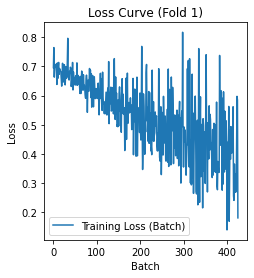

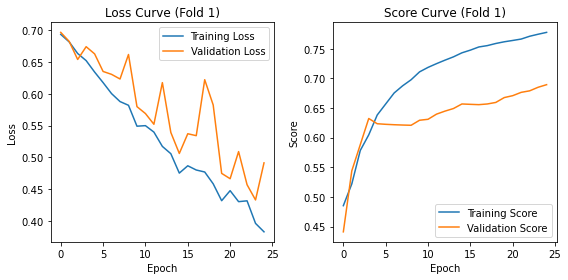

FOLD 2                                                
--------------------------------                      
Epoch 1: Training loss = 0.685, Validation loss = 0.698
Epoch 2: Training loss = 0.662, Validation loss = 0.693
Epoch 3: Training loss = 0.667, Validation loss = 0.646
Epoch 4: Training loss = 0.646, Validation loss = 0.658
Epoch 5: Training loss = 0.643, Validation loss = 0.638
Epoch 6: Training loss = 0.631, Validation loss = 0.641
Epoch 7: Training loss = 0.613, Validation loss = 0.601
Epoch 8: Training loss = 0.590, Validation loss = 0.574
Epoch 9: Training loss = 0.580, Validation loss = 0.580
Epoch 10: Training loss = 0.564, Validation loss = 0.562
Epoch 11: Training loss = 0.554, Validation loss = 0.575
Epoch 12: Training loss = 0.543, Validation loss = 0.504
Epoch 13: Training loss = 0.540, Validation loss = 0.503
Epoch 14: Training loss = 0.521, Validation loss = 0.586
Epoch 15: Training loss = 0.511, Validation loss = 0.515
Epoch 16: Training loss = 0.500, Validation 

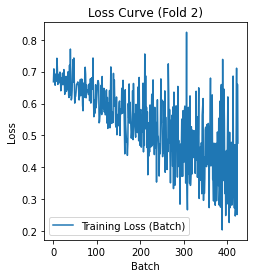

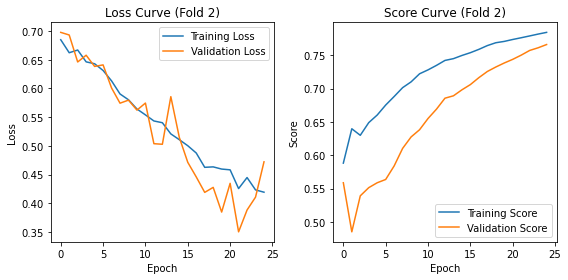

FOLD 3                                                
--------------------------------                      
Epoch 1: Training loss = 0.686, Validation loss = 0.668
Epoch 2: Training loss = 0.671, Validation loss = 0.662
Epoch 3: Training loss = 0.647, Validation loss = 0.665
Epoch 4: Training loss = 0.634, Validation loss = 0.616
Epoch 5: Training loss = 0.625, Validation loss = 0.617
Epoch 6: Training loss = 0.619, Validation loss = 0.618
Epoch 7: Training loss = 0.601, Validation loss = 0.616
Epoch 8: Training loss = 0.584, Validation loss = 0.568
Epoch 9: Training loss = 0.585, Validation loss = 0.555
Epoch 10: Training loss = 0.550, Validation loss = 0.539
Epoch 11: Training loss = 0.539, Validation loss = 0.573
Epoch 12: Training loss = 0.521, Validation loss = 0.492
Epoch 13: Training loss = 0.504, Validation loss = 0.489
Epoch 14: Training loss = 0.492, Validation loss = 0.478
Epoch 15: Training loss = 0.467, Validation loss = 0.512
Epoch 16: Training loss = 0.465, Validation 

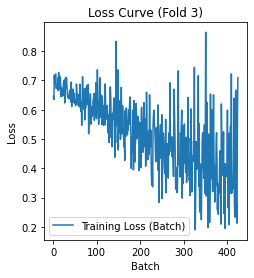

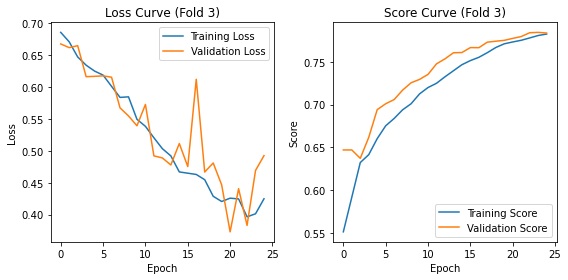

FOLD 4                                                
--------------------------------                      
Epoch 1: Training loss = 0.693, Validation loss = 0.736
Epoch 2: Training loss = 0.672, Validation loss = 0.670
Epoch 3: Training loss = 0.675, Validation loss = 0.670
Epoch 4: Training loss = 0.653, Validation loss = 0.640
Epoch 5: Training loss = 0.654, Validation loss = 0.644
Epoch 6: Training loss = 0.635, Validation loss = 0.622
Epoch 7: Training loss = 0.607, Validation loss = 0.599
Epoch 8: Training loss = 0.598, Validation loss = 0.634
Epoch 9: Training loss = 0.574, Validation loss = 0.582
Epoch 10: Training loss = 0.566, Validation loss = 0.562
Epoch 11: Training loss = 0.544, Validation loss = 0.544
Epoch 12: Training loss = 0.541, Validation loss = 0.551
Epoch 13: Training loss = 0.529, Validation loss = 0.549
Epoch 14: Training loss = 0.501, Validation loss = 0.483
Epoch 15: Training loss = 0.503, Validation loss = 0.522
Epoch 16: Training loss = 0.490, Validation 

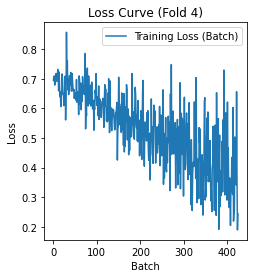

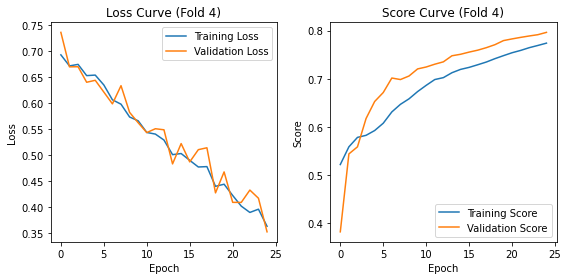

FOLD 5                                                  
--------------------------------                        
Epoch 1: Training loss = 0.705, Validation loss = 0.714 
Epoch 2: Training loss = 0.686, Validation loss = 0.685 
Epoch 3: Training loss = 0.670, Validation loss = 0.675 
Epoch 4: Training loss = 0.652, Validation loss = 0.630 
Epoch 5: Training loss = 0.640, Validation loss = 0.644 
Epoch 6: Training loss = 0.632, Validation loss = 0.632 
Epoch 7: Training loss = 0.619, Validation loss = 0.601 
Epoch 8: Training loss = 0.609, Validation loss = 0.592 
Epoch 9: Training loss = 0.600, Validation loss = 0.551 
Epoch 10: Training loss = 0.572, Validation loss = 0.553
Epoch 11: Training loss = 0.548, Validation loss = 0.560
Epoch 12: Training loss = 0.540, Validation loss = 0.522
Epoch 13: Training loss = 0.525, Validation loss = 0.565
Epoch 14: Training loss = 0.497, Validation loss = 0.490
Epoch 15: Training loss = 0.503, Validation loss = 0.506
Epoch 16: Training loss = 0.478

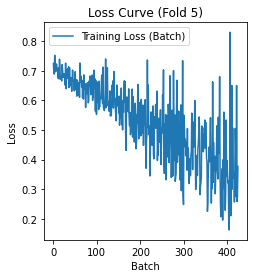

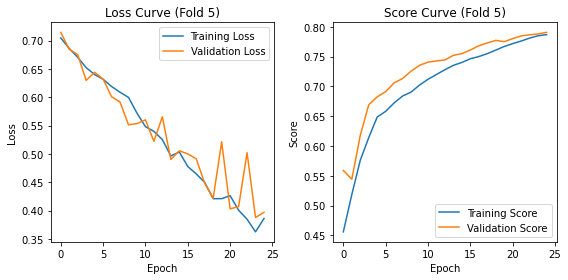

Accuracy for fold 5 = 79.059%                           

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS             
----------------------------------------------------    
Average Accuracy = 79.06%                               
                                                                                       
Selected Parameters:
+-----------------+---------------------------------+                                  
| Parameter       | Value                           |
+=================+=================================+
| dropout_rate    | 0.4683141415635439              |
+-----------------+---------------------------------+
| lr              | 0.0029161079198401383           |
+-----------------+---------------------------------+
| num_neurons_fc1 | 768                             |
+-----------------+---------------------------------+
| num_neurons_fc2 | 512                             |
+-----------------+---------------------------------+
| optimizer       | <class 'torch.

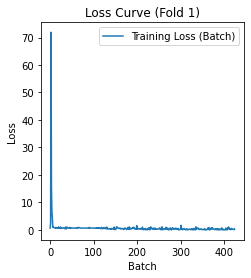

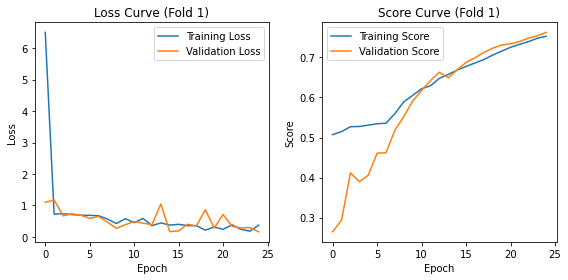

FOLD 2                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 6.413, Validation loss = 0.871                                
Epoch 2: Training loss = 0.855, Validation loss = 0.695                                
Epoch 3: Training loss = 0.763, Validation loss = 0.682                                
Epoch 4: Training loss = 0.707, Validation loss = 0.681                                
Epoch 5: Training loss = 0.705, Validation loss = 0.686                                
Epoch 6: Training loss = 0.699, Validation loss = 0.693                                
Epoch 7: Training loss = 0.750, Validation loss = 0.799                                
Epoch 8: Training loss = 0.707, Validation loss = 0.680                                
Epoch 9: Training loss = 0.697, Validation loss = 0.599                                
Epoch 10: Training loss = 0.558,

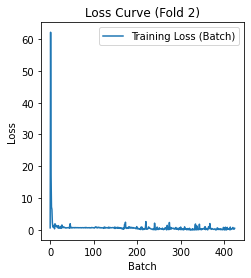

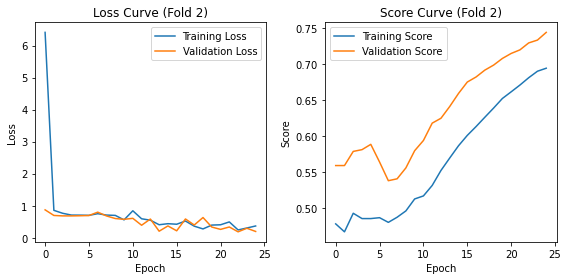

FOLD 3                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 30.141, Validation loss = 1.068                               
Epoch 2: Training loss = 1.047, Validation loss = 0.830                                
Epoch 3: Training loss = 0.773, Validation loss = 0.681                                
Epoch 4: Training loss = 0.798, Validation loss = 0.838                                
Epoch 5: Training loss = 0.734, Validation loss = 0.657                                
Epoch 6: Training loss = 0.703, Validation loss = 0.701                                
Epoch 7: Training loss = 0.707, Validation loss = 0.648                                
Epoch 8: Training loss = 0.753, Validation loss = 0.719                                
Epoch 9: Training loss = 0.703, Validation loss = 0.734                                
Epoch 10: Training loss = 0.707,

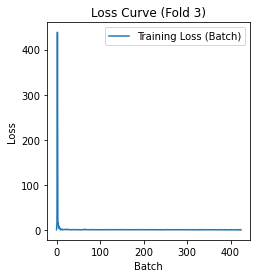

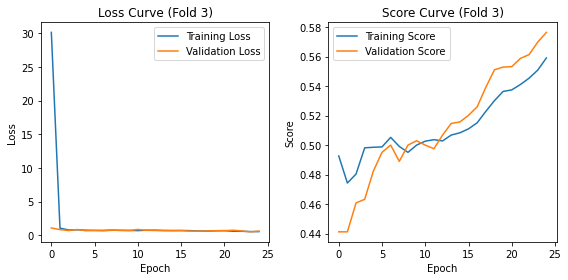

FOLD 4                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 16.595, Validation loss = 0.735                               
Epoch 2: Training loss = 0.760, Validation loss = 0.767                                
Epoch 3: Training loss = 0.742, Validation loss = 0.653                                
Epoch 4: Training loss = 0.711, Validation loss = 0.700                                
Epoch 5: Training loss = 0.697, Validation loss = 0.681                                
Epoch 6: Training loss = 0.688, Validation loss = 0.786                                
Epoch 7: Training loss = 0.737, Validation loss = 0.665                                
Epoch 8: Training loss = 0.744, Validation loss = 0.758                                
Epoch 9: Training loss = 0.725, Validation loss = 0.779                                
Epoch 10: Training loss = 0.717,

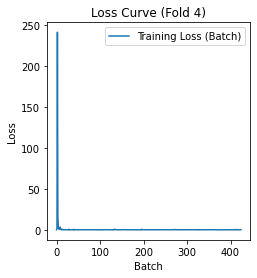

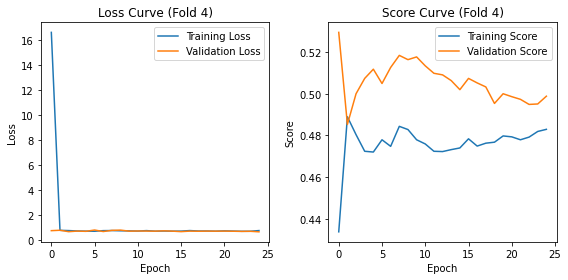

FOLD 5                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 9.962, Validation loss = 0.804                                
Epoch 2: Training loss = 0.897, Validation loss = 0.680                                
Epoch 3: Training loss = 0.755, Validation loss = 0.678                                
Epoch 4: Training loss = 0.694, Validation loss = 0.669                                
Epoch 5: Training loss = 0.721, Validation loss = 0.689                                
Epoch 6: Training loss = 0.727, Validation loss = 0.756                                
Epoch 7: Training loss = 0.701, Validation loss = 0.686                                
Epoch 8: Training loss = 0.695, Validation loss = 0.648                                
Epoch 9: Training loss = 0.711, Validation loss = 0.691                                
Epoch 10: Training loss = 0.711,

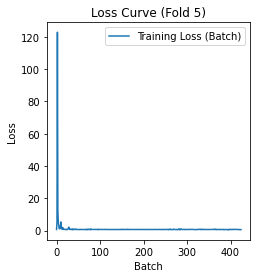

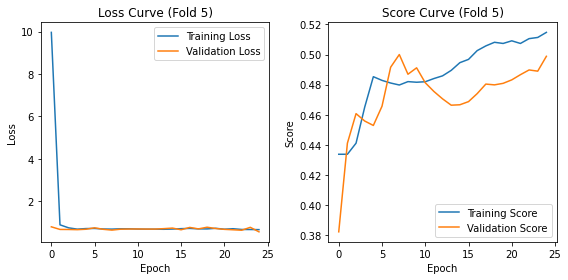

Accuracy for fold 5 = 49.882%                                                          

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS                                            
----------------------------------------------------                                   
Average Accuracy = 49.88%                                                              
                                                                                       
Selected Parameters:
+-----------------+---------------------------------+                                  
| Parameter       | Value                           |
+=================+=================================+
| dropout_rate    | 0.2633384630033595              |
+-----------------+---------------------------------+
| lr              | 0.0009465131179747426           |
+-----------------+---------------------------------+
| num_neurons_fc1 | 768                             |
+-----------------+---------------------------------+
| num_neurons_fc2 

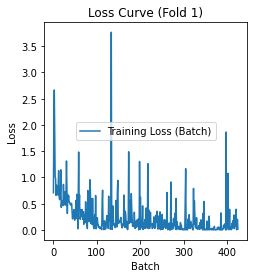

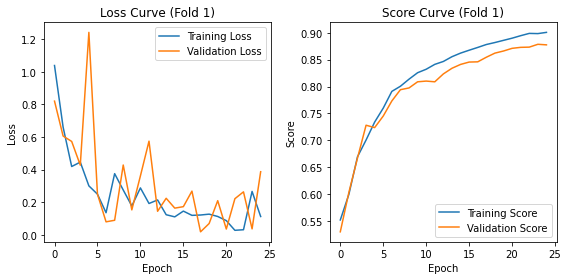

FOLD 2                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 2.162, Validation loss = 0.737                                
Epoch 2: Training loss = 0.736, Validation loss = 0.659                                
Epoch 3: Training loss = 0.655, Validation loss = 0.518                                
Epoch 4: Training loss = 0.633, Validation loss = 0.488                                
Epoch 5: Training loss = 0.588, Validation loss = 0.420                                
Epoch 6: Training loss = 0.553, Validation loss = 0.532                                
Epoch 7: Training loss = 0.472, Validation loss = 0.102                                
Epoch 8: Training loss = 0.296, Validation loss = 0.128                                
Epoch 9: Training loss = 0.396, Validation loss = 0.411                                
Epoch 10: Training loss = 0.292,

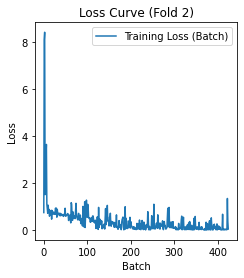

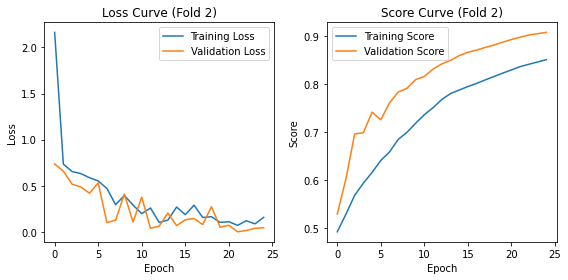

FOLD 3                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 3.338, Validation loss = 0.684                                
Epoch 2: Training loss = 0.661, Validation loss = 0.586                                
Epoch 3: Training loss = 0.613, Validation loss = 0.791                                
Epoch 4: Training loss = 0.534, Validation loss = 0.491                                
Epoch 5: Training loss = 0.271, Validation loss = 0.679                                
Epoch 6: Training loss = 0.365, Validation loss = 0.532                                
Epoch 7: Training loss = 0.430, Validation loss = 0.587                                
Epoch 8: Training loss = 0.247, Validation loss = 0.487                                
Epoch 9: Training loss = 0.180, Validation loss = 1.440                                
Epoch 10: Training loss = 0.112,

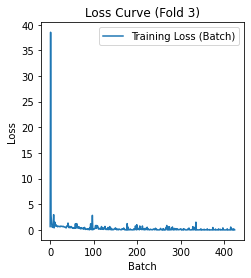

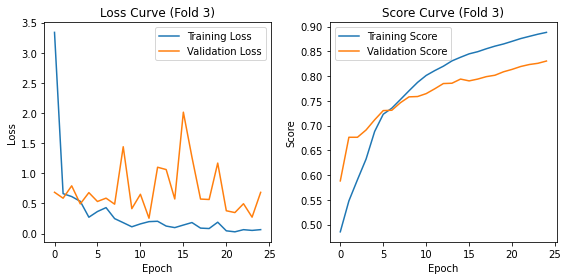

FOLD 4                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 2.165, Validation loss = 0.703                                
Epoch 2: Training loss = 0.709, Validation loss = 0.698                                
Epoch 3: Training loss = 0.696, Validation loss = 0.672                                
Epoch 4: Training loss = 0.681, Validation loss = 0.665                                
Epoch 5: Training loss = 0.679, Validation loss = 0.752                                
Epoch 6: Training loss = 0.705, Validation loss = 0.671                                
Epoch 7: Training loss = 0.660, Validation loss = 0.645                                
Epoch 8: Training loss = 0.614, Validation loss = 0.538                                
Epoch 9: Training loss = 0.498, Validation loss = 0.517                                
Epoch 10: Training loss = 0.469,

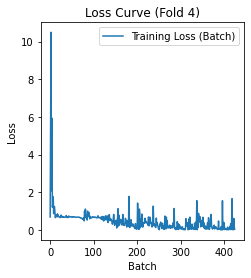

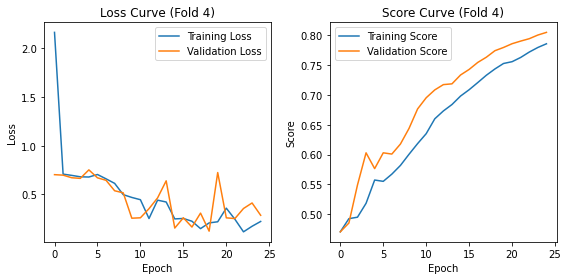

FOLD 5                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 2.223, Validation loss = 0.752                                
Epoch 2: Training loss = 0.751, Validation loss = 0.729                                
Epoch 3: Training loss = 0.690, Validation loss = 0.676                                
Epoch 4: Training loss = 0.687, Validation loss = 0.703                                
Epoch 5: Training loss = 0.662, Validation loss = 0.619                                
Epoch 6: Training loss = 0.591, Validation loss = 0.516                                
Epoch 7: Training loss = 0.629, Validation loss = 0.646                                
Epoch 8: Training loss = 0.548, Validation loss = 0.395                                
Epoch 9: Training loss = 0.533, Validation loss = 0.844                                
Epoch 10: Training loss = 0.492,

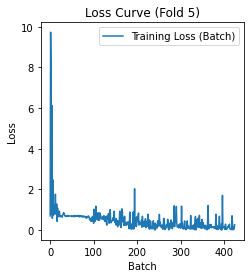

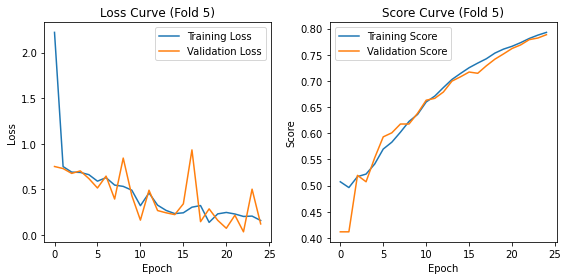

Accuracy for fold 5 = 78.824%                                                          

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS                                            
----------------------------------------------------                                   
Average Accuracy = 78.82%                                                              
                                                                                       
Selected Parameters:
+-----------------+---------------------------------+                                  
| Parameter       | Value                           |
+=================+=================================+
| dropout_rate    | 0.24048750872539326             |
+-----------------+---------------------------------+
| lr              | 0.00044184167356285713          |
+-----------------+---------------------------------+
| num_neurons_fc1 | 1024                            |
+-----------------+---------------------------------+
| num_neurons_fc2 

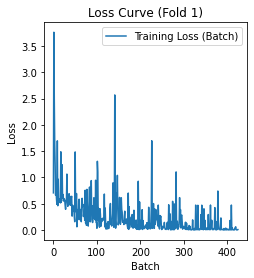

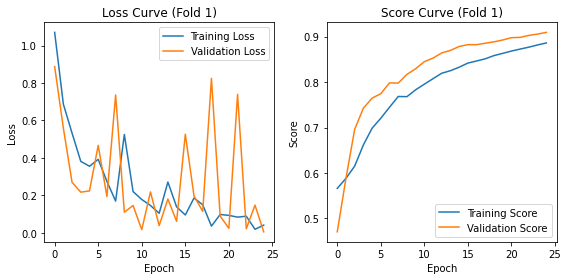

FOLD 2                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 2.615, Validation loss = 0.963                                
Epoch 2: Training loss = 0.871, Validation loss = 0.647                                
Epoch 3: Training loss = 0.660, Validation loss = 0.598                                
Epoch 4: Training loss = 0.642, Validation loss = 0.606                                
Epoch 5: Training loss = 0.561, Validation loss = 0.476                                
Epoch 6: Training loss = 0.526, Validation loss = 0.405                                
Epoch 7: Training loss = 0.367, Validation loss = 0.416                                
Epoch 8: Training loss = 0.222, Validation loss = 0.403                                
Epoch 9: Training loss = 0.288, Validation loss = 0.740                                
Epoch 10: Training loss = 0.351,

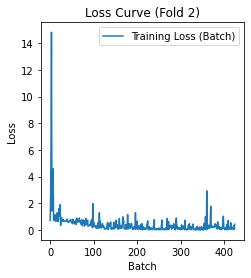

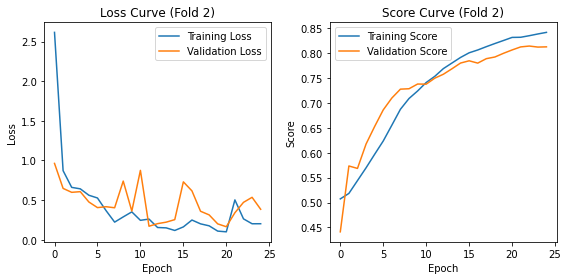

FOLD 3                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 2.286, Validation loss = 0.690                                
Epoch 2: Training loss = 0.695, Validation loss = 0.640                                
Epoch 3: Training loss = 0.605, Validation loss = 0.572                                
Epoch 4: Training loss = 0.594, Validation loss = 0.496                                
Epoch 5: Training loss = 0.562, Validation loss = 0.446                                
Epoch 6: Training loss = 0.412, Validation loss = 0.407                                
Epoch 7: Training loss = 0.377, Validation loss = 0.331                                
Epoch 8: Training loss = 0.240, Validation loss = 0.196                                
Epoch 9: Training loss = 0.206, Validation loss = 0.173                                
Epoch 10: Training loss = 0.148,

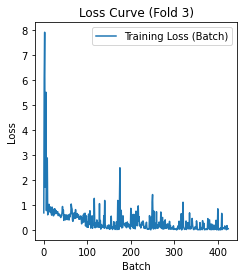

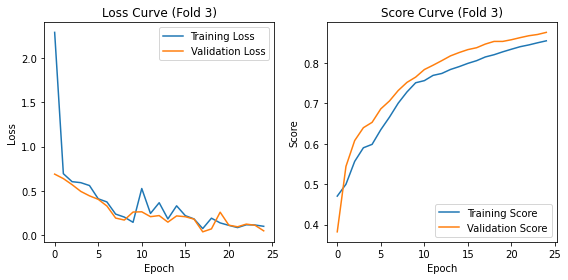

FOLD 4                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 2.400, Validation loss = 0.699                                
Epoch 2: Training loss = 0.705, Validation loss = 0.766                                
Epoch 3: Training loss = 0.714, Validation loss = 0.669                                
Epoch 4: Training loss = 0.672, Validation loss = 0.665                                
Epoch 5: Training loss = 0.628, Validation loss = 0.568                                
Epoch 6: Training loss = 0.611, Validation loss = 0.943                                
Epoch 7: Training loss = 0.624, Validation loss = 0.494                                
Epoch 8: Training loss = 0.461, Validation loss = 0.386                                
Epoch 9: Training loss = 0.425, Validation loss = 0.371                                
Epoch 10: Training loss = 0.407,

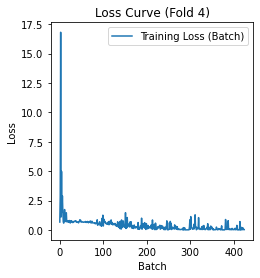

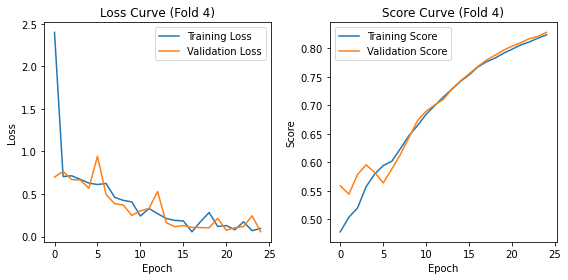

FOLD 5                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 1.932, Validation loss = 0.754                                
Epoch 2: Training loss = 0.770, Validation loss = 0.707                                
Epoch 3: Training loss = 0.696, Validation loss = 0.661                                
Epoch 4: Training loss = 0.723, Validation loss = 0.634                                
Epoch 5: Training loss = 0.665, Validation loss = 0.641                                
Epoch 6: Training loss = 0.654, Validation loss = 0.590                                
Epoch 7: Training loss = 0.589, Validation loss = 0.486                                
Epoch 8: Training loss = 0.523, Validation loss = 0.347                                
Epoch 9: Training loss = 0.408, Validation loss = 0.673                                
Epoch 10: Training loss = 0.333,

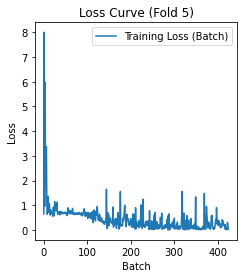

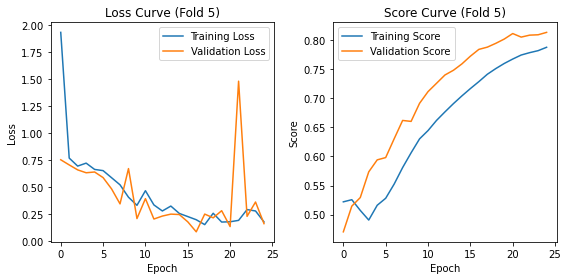

Accuracy for fold 5 = 81.294%                                                          

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS                                            
----------------------------------------------------                                   
Average Accuracy = 81.29%                                                              
                                                                                       
Selected Parameters:
+-----------------+---------------------------------+                                 
| Parameter       | Value                           |
+=================+=================================+
| dropout_rate    | 0.4880700596575265              |
+-----------------+---------------------------------+
| lr              | 0.00020762885639534018          |
+-----------------+---------------------------------+
| num_neurons_fc1 | 512                             |
+-----------------+---------------------------------+
| num_neurons_fc2 |

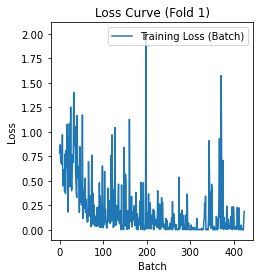

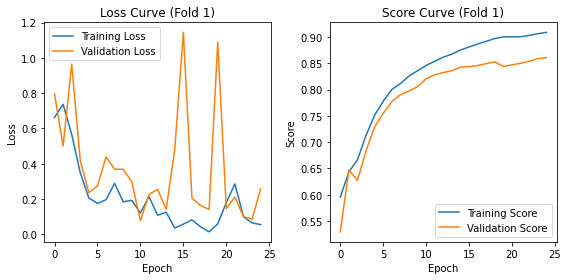

FOLD 2                                                                                
--------------------------------                                                      
Epoch 1: Training loss = 1.015, Validation loss = 0.773                               
Epoch 2: Training loss = 0.889, Validation loss = 1.302                               
Epoch 3: Training loss = 0.730, Validation loss = 0.403                               
Epoch 4: Training loss = 0.486, Validation loss = 0.418                               
Epoch 5: Training loss = 0.351, Validation loss = 0.669                               
Epoch 6: Training loss = 0.217, Validation loss = 0.239                               
Epoch 7: Training loss = 0.354, Validation loss = 0.220                               
Epoch 8: Training loss = 0.244, Validation loss = 0.202                               
Epoch 9: Training loss = 0.235, Validation loss = 0.103                               
Epoch 10: Training loss = 0.498, Validation

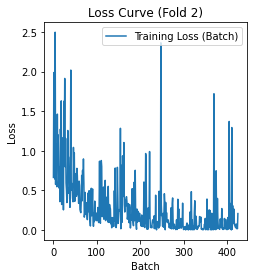

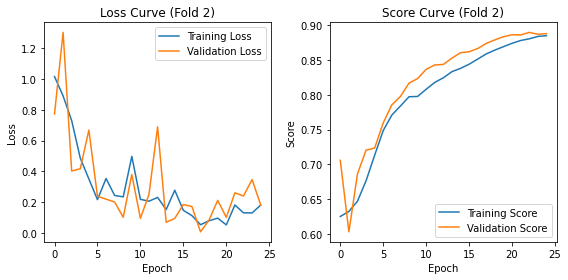

FOLD 3                                                                                
--------------------------------                                                      
Epoch 1: Training loss = 2.092, Validation loss = 3.225                               
Epoch 2: Training loss = 1.318, Validation loss = 0.623                               
Epoch 3: Training loss = 0.651, Validation loss = 0.566                               
Epoch 4: Training loss = 0.518, Validation loss = 0.395                               
Epoch 5: Training loss = 0.519, Validation loss = 0.292                               
Epoch 6: Training loss = 0.334, Validation loss = 0.249                               
Epoch 7: Training loss = 0.314, Validation loss = 0.289                               
Epoch 8: Training loss = 0.369, Validation loss = 0.221                               
Epoch 9: Training loss = 0.235, Validation loss = 0.502                               
Epoch 10: Training loss = 0.353, Validation

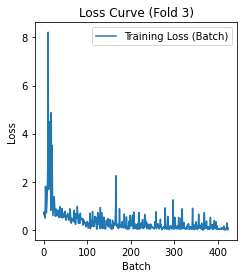

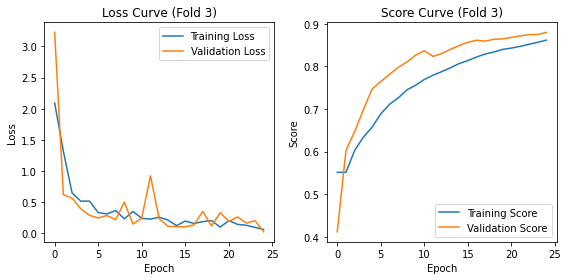

FOLD 4                                                                                
--------------------------------                                                      
Epoch 1: Training loss = 1.349, Validation loss = 1.045                               
Epoch 2: Training loss = 0.928, Validation loss = 0.593                               
Epoch 3: Training loss = 0.631, Validation loss = 0.508                               
Epoch 4: Training loss = 0.489, Validation loss = 0.503                               
Epoch 5: Training loss = 0.386, Validation loss = 0.439                               
Epoch 6: Training loss = 0.275, Validation loss = 0.274                               
Epoch 7: Training loss = 0.167, Validation loss = 0.239                               
Epoch 8: Training loss = 0.219, Validation loss = 0.232                               
Epoch 9: Training loss = 0.105, Validation loss = 0.255                               
Epoch 10: Training loss = 0.292, Validation

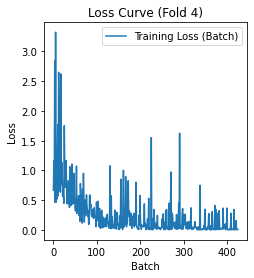

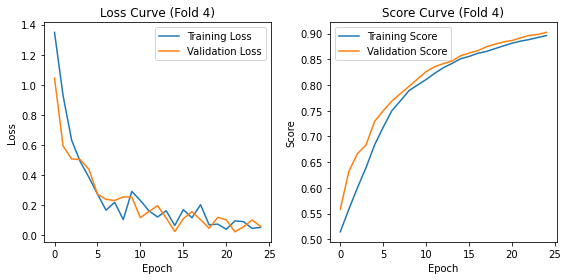

FOLD 5                                                                                
--------------------------------                                                      
Epoch 1: Training loss = 1.892, Validation loss = 0.997                               
Epoch 2: Training loss = 0.802, Validation loss = 0.685                               
Epoch 3: Training loss = 0.693, Validation loss = 0.611                               
Epoch 4: Training loss = 0.647, Validation loss = 0.624                               
Epoch 5: Training loss = 0.551, Validation loss = 0.471                               
Epoch 6: Training loss = 0.560, Validation loss = 0.439                               
Epoch 7: Training loss = 0.386, Validation loss = 0.344                               
Epoch 8: Training loss = 0.412, Validation loss = 0.312                               
Epoch 9: Training loss = 0.385, Validation loss = 0.463                               
Epoch 10: Training loss = 0.257, Validation

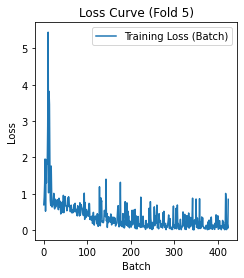

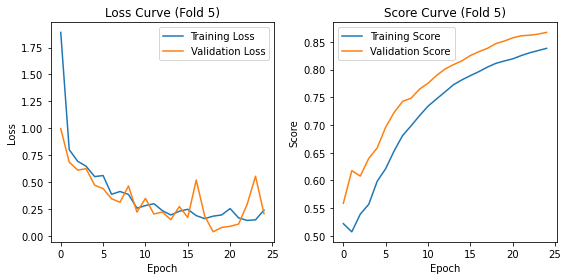

Accuracy for fold 5 = 86.706%                                                         

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS                                           
----------------------------------------------------                                  
Average Accuracy = 86.71%                                                             
                                                                                      
Selected Parameters:
+-----------------+---------------------------------+                                 
| Parameter       | Value                           |
+=================+=================================+
| dropout_rate    | 0.14966059760359957             |
+-----------------+---------------------------------+
| lr              | 0.007526782128581262            |
+-----------------+---------------------------------+
| num_neurons_fc1 | 1024                            |
+-----------------+---------------------------------+
| num_neurons_fc2 | 768 

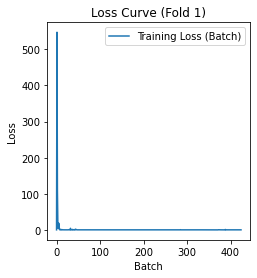

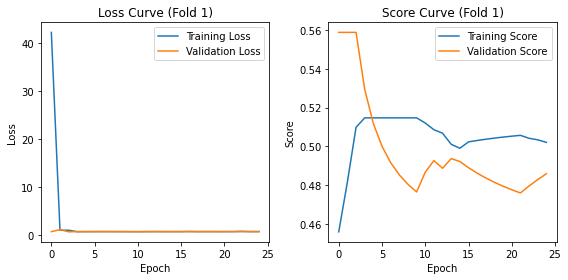

FOLD 2                                                                                
--------------------------------                                                      
Epoch 1: Training loss = 107.796, Validation loss = 3.497                             
Epoch 2: Training loss = 1.205, Validation loss = 0.800                               
Epoch 3: Training loss = 0.795, Validation loss = 0.643                               
Epoch 4: Training loss = 0.672, Validation loss = 0.720                               
Epoch 5: Training loss = 0.793, Validation loss = 0.710                               
Epoch 6: Training loss = 0.704, Validation loss = 0.695                               
Epoch 7: Training loss = 0.751, Validation loss = 0.693                               
Epoch 8: Training loss = 0.704, Validation loss = 0.711                               
Epoch 9: Training loss = 0.697, Validation loss = 0.661                               
Epoch 10: Training loss = 0.703, Validation

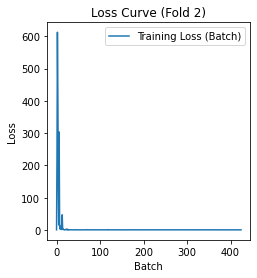

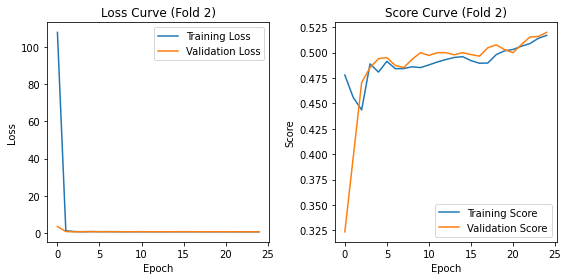

FOLD 3                                                                                
--------------------------------                                                      
Epoch 1: Training loss = 47.970, Validation loss = 0.890                              
Epoch 2: Training loss = 0.916, Validation loss = 0.696                               
Epoch 3: Training loss = 1.167, Validation loss = 0.698                               
Epoch 4: Training loss = 0.700, Validation loss = 0.693                               
Epoch 5: Training loss = 0.728, Validation loss = 0.695                               
Epoch 6: Training loss = 0.695, Validation loss = 0.692                               
Epoch 7: Training loss = 0.694, Validation loss = 0.693                               
Epoch 8: Training loss = 0.697, Validation loss = 0.689                               
Epoch 9: Training loss = 0.704, Validation loss = 0.688                               
Epoch 10: Training loss = 0.694, Validation

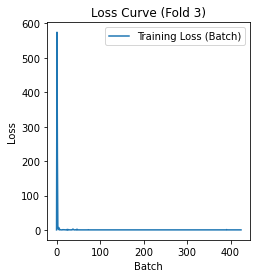

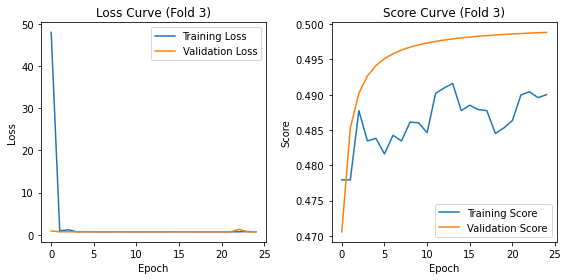

FOLD 4                                                                                
--------------------------------                                                      
Epoch 1: Training loss = 75.784, Validation loss = 1.642                              
Epoch 2: Training loss = 0.876, Validation loss = 0.736                               
Epoch 3: Training loss = 0.707, Validation loss = 0.721                               
Epoch 4: Training loss = 0.763, Validation loss = 0.701                               
Epoch 5: Training loss = 0.714, Validation loss = 0.694                               
Epoch 6: Training loss = 0.703, Validation loss = 0.691                               
Epoch 7: Training loss = 0.706, Validation loss = 0.695                               
Epoch 8: Training loss = 0.702, Validation loss = 0.697                               
Epoch 9: Training loss = 0.695, Validation loss = 0.695                               
Epoch 10: Training loss = 0.693, Validation

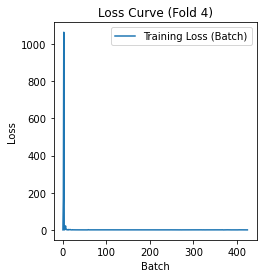

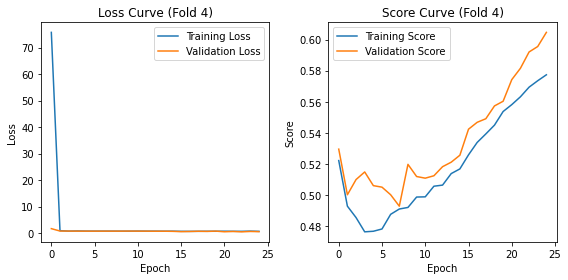

FOLD 5                                                                                
--------------------------------                                                      
Epoch 1: Training loss = 37.914, Validation loss = 0.972                              
Epoch 2: Training loss = 0.953, Validation loss = 0.738                               
Epoch 3: Training loss = 0.707, Validation loss = 0.682                               
Epoch 4: Training loss = 0.703, Validation loss = 0.693                               
Epoch 5: Training loss = 0.696, Validation loss = 0.688                               
Epoch 6: Training loss = 0.700, Validation loss = 0.694                               
Epoch 7: Training loss = 0.695, Validation loss = 0.693                               
Epoch 8: Training loss = 0.696, Validation loss = 0.697                               
Epoch 9: Training loss = 0.693, Validation loss = 0.693                               
Epoch 10: Training loss = 0.695, Validation

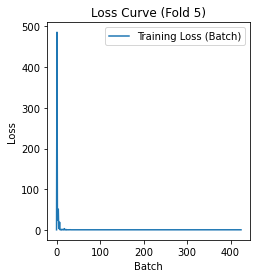

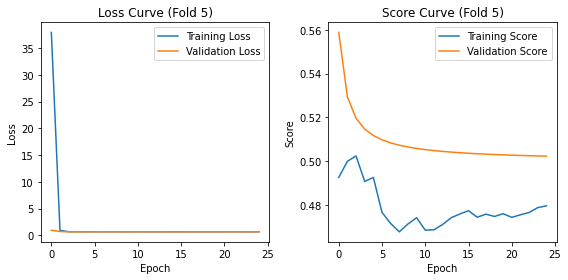

Accuracy for fold 5 = 50.235%                                                         

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS                                           
----------------------------------------------------                                  
Average Accuracy = 50.24%                                                             
                                                                                      
Selected Parameters:
+-----------------+---------------------------------+                                 
| Parameter       | Value                           |
+=================+=================================+
| dropout_rate    | 0.388207020606839               |
+-----------------+---------------------------------+
| lr              | 0.0042359412652601715           |
+-----------------+---------------------------------+
| num_neurons_fc1 | 1024                            |
+-----------------+---------------------------------+
| num_neurons_fc2 | 1024

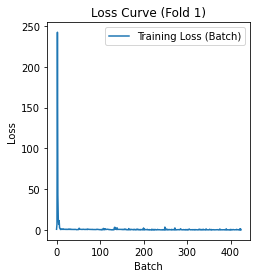

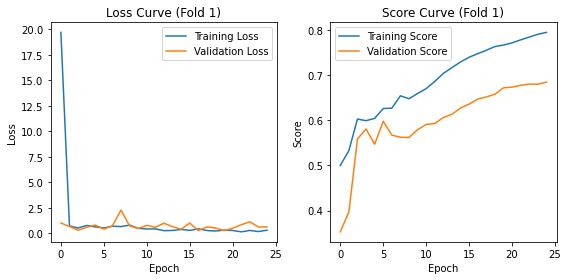

FOLD 2                                                                                
--------------------------------                                                      
Epoch 1: Training loss = 32.585, Validation loss = 1.533                              
Epoch 2: Training loss = 0.961, Validation loss = 0.652                               
Epoch 3: Training loss = 0.741, Validation loss = 0.816                               
Epoch 4: Training loss = 0.771, Validation loss = 0.678                               
Epoch 5: Training loss = 0.748, Validation loss = 0.710                               
Epoch 6: Training loss = 0.715, Validation loss = 0.647                               
Epoch 7: Training loss = 0.710, Validation loss = 0.703                               
Epoch 8: Training loss = 0.708, Validation loss = 0.658                               
Epoch 9: Training loss = 0.760, Validation loss = 0.689                               
Epoch 10: Training loss = 0.698, Validation

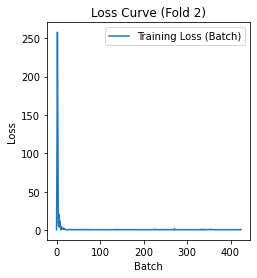

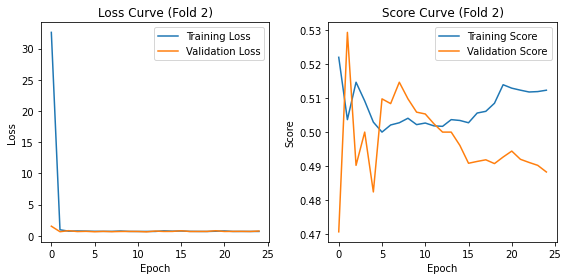

FOLD 3                                                                                
--------------------------------                                                      
Epoch 1: Training loss = 58.648, Validation loss = 1.136                              
Epoch 2: Training loss = 1.014, Validation loss = 0.777                               
Epoch 3: Training loss = 1.532, Validation loss = 0.778                               
Epoch 4: Training loss = 0.726, Validation loss = 0.722                               
Epoch 5: Training loss = 0.715, Validation loss = 0.710                               
Epoch 6: Training loss = 0.691, Validation loss = 0.712                               
Epoch 7: Training loss = 0.708, Validation loss = 0.682                               
Epoch 8: Training loss = 0.694, Validation loss = 0.739                               
Epoch 9: Training loss = 0.689, Validation loss = 0.740                               
Epoch 10: Training loss = 0.687, Validation

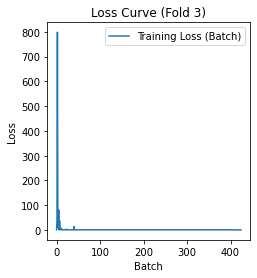

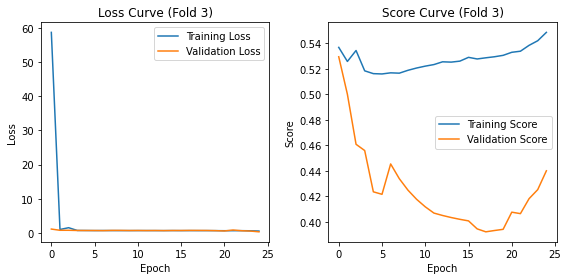

FOLD 4                                                                                
--------------------------------                                                      
Epoch 1: Training loss = 34.353, Validation loss = 0.698                              
Epoch 2: Training loss = 0.835, Validation loss = 0.979                               
Epoch 3: Training loss = 0.870, Validation loss = 0.659                               
Epoch 4: Training loss = 0.752, Validation loss = 0.657                               
Epoch 5: Training loss = 0.735, Validation loss = 0.637                               
Epoch 6: Training loss = 0.741, Validation loss = 0.666                               
Epoch 7: Training loss = 0.726, Validation loss = 0.667                               
Epoch 8: Training loss = 0.795, Validation loss = 0.705                               
Epoch 9: Training loss = 0.817, Validation loss = 0.614                               
Epoch 10: Training loss = 0.712, Validation

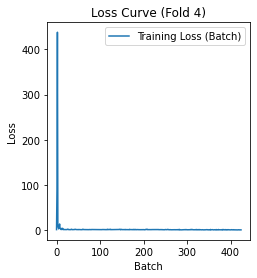

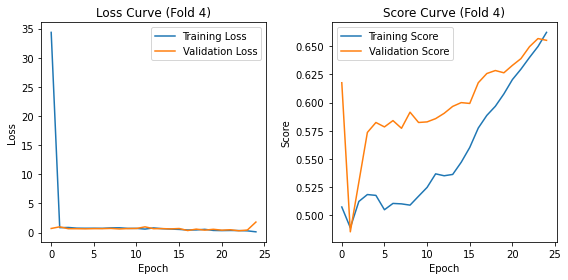

FOLD 5                                                                                
--------------------------------                                                      
Epoch 1: Training loss = 15.602, Validation loss = 1.376                              
Epoch 2: Training loss = 1.129, Validation loss = 0.769                               
Epoch 3: Training loss = 0.865, Validation loss = 0.897                               
Epoch 4: Training loss = 0.726, Validation loss = 0.747                               
Epoch 5: Training loss = 0.736, Validation loss = 0.768                               
Epoch 6: Training loss = 0.695, Validation loss = 0.741                               
Epoch 7: Training loss = 0.797, Validation loss = 0.816                               
Epoch 8: Training loss = 0.724, Validation loss = 0.699                               
Epoch 9: Training loss = 0.699, Validation loss = 0.712                               
Epoch 10: Training loss = 0.735, Validation

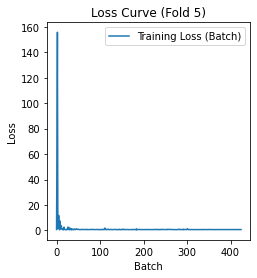

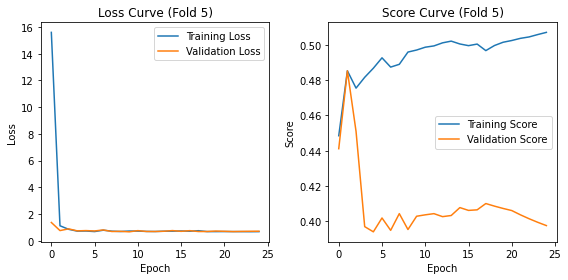

Accuracy for fold 5 = 39.765%                                                         

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS                                           
----------------------------------------------------                                  
Average Accuracy = 39.76%                                                             
                                                                                      
Selected Parameters:
+-----------------+---------------------------------+                                 
| Parameter       | Value                           |
+=================+=================================+
| dropout_rate    | 0.1446344103451589              |
+-----------------+---------------------------------+
| lr              | 0.0068613649542841664           |
+-----------------+---------------------------------+
| num_neurons_fc1 | 256                             |
+-----------------+---------------------------------+
| num_neurons_fc2 | 256 

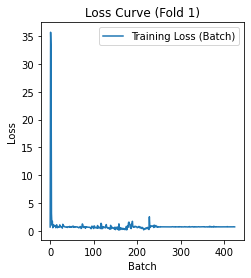

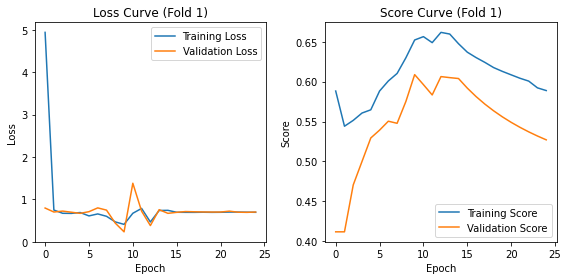

FOLD 2                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 12.096, Validation loss = 1.262                               
Epoch 2: Training loss = 1.181, Validation loss = 0.691                                
Epoch 3: Training loss = 0.685, Validation loss = 0.715                                
Epoch 4: Training loss = 0.696, Validation loss = 0.708                                
Epoch 5: Training loss = 0.696, Validation loss = 0.699                                
Epoch 6: Training loss = 0.693, Validation loss = 0.694                                
Epoch 7: Training loss = 0.694, Validation loss = 0.702                                
Epoch 8: Training loss = 0.693, Validation loss = 0.695                                
Epoch 9: Training loss = 0.694, Validation loss = 0.699                                
Epoch 10: Training loss = 0.698,

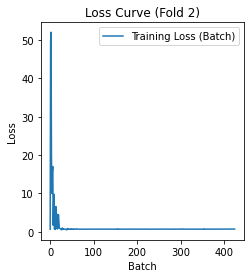

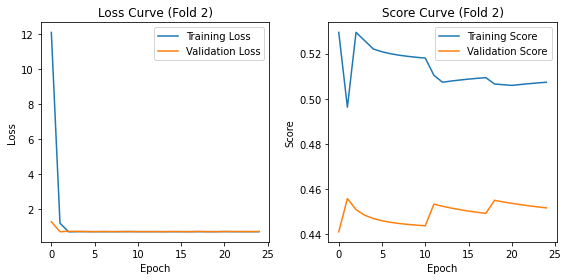

FOLD 3                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 9.595, Validation loss = 0.676                                
Epoch 2: Training loss = 0.857, Validation loss = 0.612                                
Epoch 3: Training loss = 0.703, Validation loss = 0.715                                
Epoch 4: Training loss = 0.698, Validation loss = 0.690                                
Epoch 5: Training loss = 0.694, Validation loss = 0.696                                
Epoch 6: Training loss = 0.695, Validation loss = 0.702                                
Epoch 7: Training loss = 0.701, Validation loss = 0.689                                
Epoch 8: Training loss = 0.693, Validation loss = 0.698                                
Epoch 9: Training loss = 0.695, Validation loss = 0.692                                
Epoch 10: Training loss = 0.694,

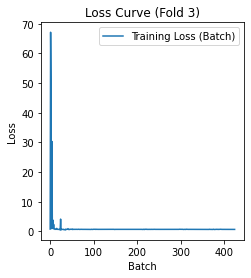

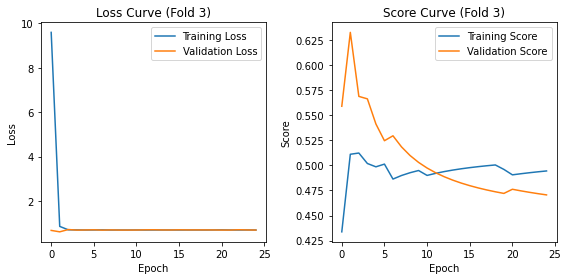

FOLD 4                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 8.874, Validation loss = 0.974                                
Epoch 2: Training loss = 0.794, Validation loss = 0.697                                
Epoch 3: Training loss = 0.701, Validation loss = 0.689                                
Epoch 4: Training loss = 0.703, Validation loss = 0.692                                
Epoch 5: Training loss = 0.695, Validation loss = 0.692                                
Epoch 6: Training loss = 0.694, Validation loss = 0.694                                
Epoch 7: Training loss = 0.693, Validation loss = 0.694                                
Epoch 8: Training loss = 0.694, Validation loss = 0.696                                
Epoch 9: Training loss = 0.693, Validation loss = 0.694                                
Epoch 10: Training loss = 0.693,

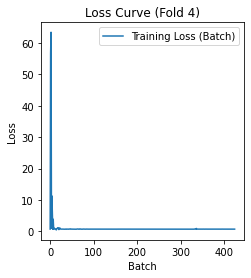

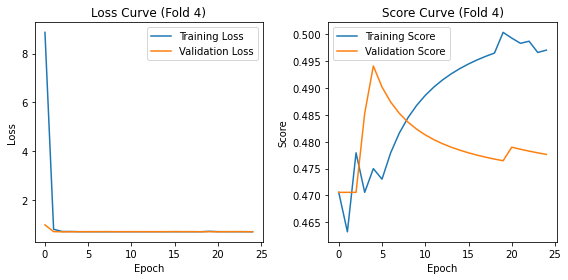

FOLD 5                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 10.768, Validation loss = 0.712                               
Epoch 2: Training loss = 0.896, Validation loss = 0.637                                
Epoch 3: Training loss = 0.734, Validation loss = 0.713                                
Epoch 4: Training loss = 0.690, Validation loss = 0.697                                
Epoch 5: Training loss = 0.851, Validation loss = 0.716                                
Epoch 6: Training loss = 0.704, Validation loss = 0.724                                
Epoch 7: Training loss = 0.698, Validation loss = 0.721                                
Epoch 8: Training loss = 0.687, Validation loss = 0.724                                
Epoch 9: Training loss = 0.687, Validation loss = 0.745                                
Epoch 10: Training loss = 0.681,

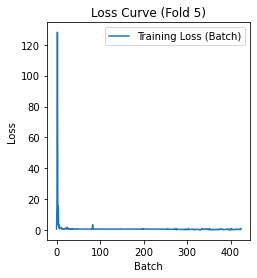

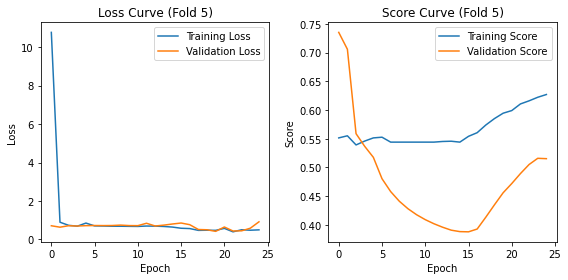

Accuracy for fold 5 = 51.529%                                                          

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS                                            
----------------------------------------------------                                   
Average Accuracy = 51.53%                                                              
                                                                                       
Selected Parameters:
+-----------------+---------------------------------+                                  
| Parameter       | Value                           |
+=================+=================================+
| dropout_rate    | 0.23636040856468626             |
+-----------------+---------------------------------+
| lr              | 0.0005252318238362778           |
+-----------------+---------------------------------+
| num_neurons_fc1 | 512                             |
+-----------------+---------------------------------+
| num_neurons_fc2 

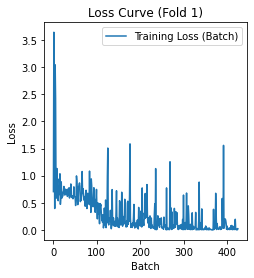

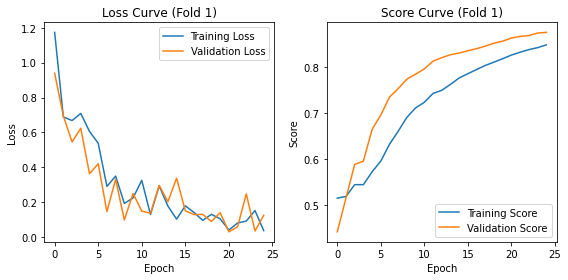

FOLD 2                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 1.492, Validation loss = 0.673                                
Epoch 2: Training loss = 0.833, Validation loss = 0.689                                
Epoch 3: Training loss = 0.647, Validation loss = 0.618                                
Epoch 4: Training loss = 0.494, Validation loss = 0.229                                
Epoch 5: Training loss = 0.386, Validation loss = 0.553                                
Epoch 6: Training loss = 0.466, Validation loss = 0.431                                
Epoch 7: Training loss = 0.488, Validation loss = 0.295                                
Epoch 8: Training loss = 0.333, Validation loss = 0.293                                
Epoch 9: Training loss = 0.414, Validation loss = 0.282                                
Epoch 10: Training loss = 0.240,

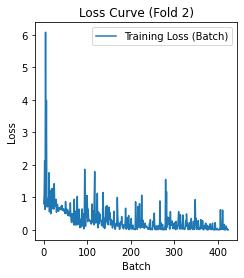

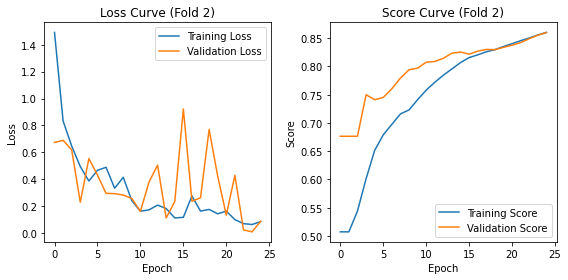

FOLD 3                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 1.400, Validation loss = 0.697                                
Epoch 2: Training loss = 0.583, Validation loss = 0.617                                
Epoch 3: Training loss = 0.523, Validation loss = 0.367                                
Epoch 4: Training loss = 0.408, Validation loss = 0.755                                
Epoch 5: Training loss = 0.733, Validation loss = 0.606                                
Epoch 6: Training loss = 0.414, Validation loss = 0.471                                
Epoch 7: Training loss = 0.273, Validation loss = 1.451                                
Epoch 8: Training loss = 0.422, Validation loss = 0.466                                
Epoch 9: Training loss = 0.287, Validation loss = 0.217                                
Epoch 10: Training loss = 0.206,

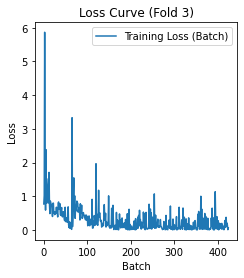

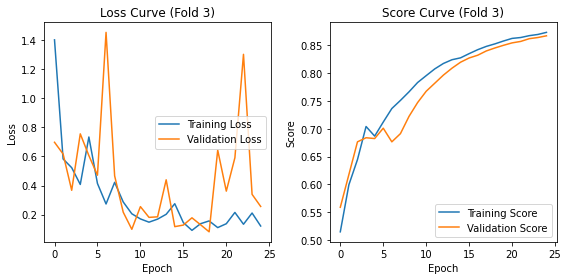

FOLD 4                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 1.540, Validation loss = 0.640                                
Epoch 2: Training loss = 0.703, Validation loss = 0.634                                
Epoch 3: Training loss = 0.643, Validation loss = 0.568                                
Epoch 4: Training loss = 0.579, Validation loss = 0.506                                
Epoch 5: Training loss = 0.438, Validation loss = 0.456                                
Epoch 6: Training loss = 0.524, Validation loss = 0.682                                
Epoch 7: Training loss = 0.451, Validation loss = 0.296                                
Epoch 8: Training loss = 0.346, Validation loss = 0.237                                
Epoch 9: Training loss = 0.334, Validation loss = 0.167                                
Epoch 10: Training loss = 0.221,

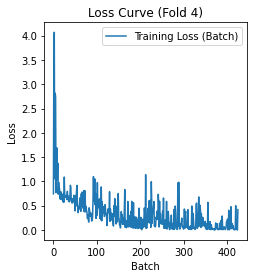

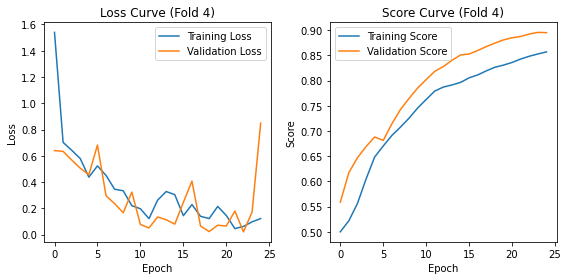

FOLD 5                                                                                 
--------------------------------                                                       
Epoch 1: Training loss = 2.006, Validation loss = 0.948                                
Epoch 2: Training loss = 0.738, Validation loss = 0.710                                
Epoch 3: Training loss = 0.725, Validation loss = 0.718                                
Epoch 4: Training loss = 0.727, Validation loss = 0.692                                
Epoch 5: Training loss = 0.687, Validation loss = 0.686                                
Epoch 6: Training loss = 0.668, Validation loss = 0.662                                
Epoch 7: Training loss = 0.624, Validation loss = 0.602                                
Epoch 8: Training loss = 0.609, Validation loss = 0.712                                
Epoch 9: Training loss = 0.554, Validation loss = 0.698                                
Epoch 10: Training loss = 0.510,

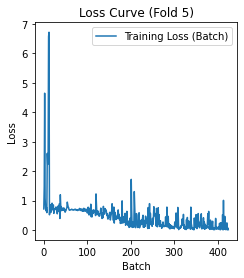

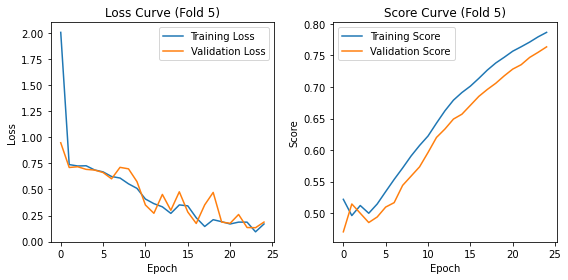

Accuracy for fold 5 = 76.353%                                                          

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS                                            
----------------------------------------------------                                   
Average Accuracy = 76.35%                                                              
                                                                                        
Selected Parameters:
+-----------------+---------------------------------+                                   
| Parameter       | Value                           |
+=================+=================================+
| dropout_rate    | 0.17349650386995186             |
+-----------------+---------------------------------+
| lr              | 0.009958284481951758            |
+-----------------+---------------------------------+
| num_neurons_fc1 | 512                             |
+-----------------+---------------------------------+
| num_neurons_fc

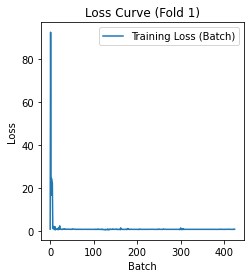

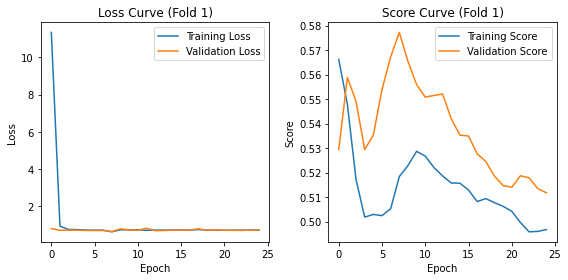

FOLD 2                                                                                  
--------------------------------                                                        
Epoch 1: Training loss = 69.605, Validation loss = 23.287                               
Epoch 2: Training loss = 4.403, Validation loss = 0.740                                 
Epoch 3: Training loss = 0.752, Validation loss = 0.757                                 
Epoch 4: Training loss = 0.727, Validation loss = 0.604                                 
Epoch 5: Training loss = 0.646, Validation loss = 0.624                                 
Epoch 6: Training loss = 0.583, Validation loss = 0.585                                 
Epoch 7: Training loss = 0.668, Validation loss = 0.553                                 
Epoch 8: Training loss = 0.535, Validation loss = 0.705                                 
Epoch 9: Training loss = 0.694, Validation loss = 0.583                                 
Epoch 10: Training lo

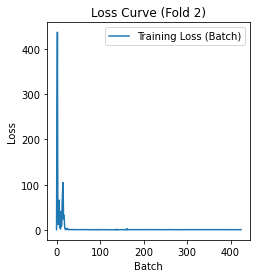

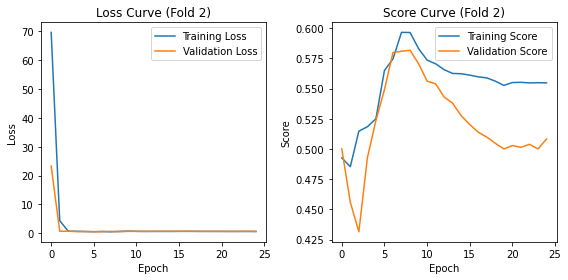

FOLD 3                                                                                  
--------------------------------                                                        
Epoch 1: Training loss = 38.383, Validation loss = 1.219                                
Epoch 2: Training loss = 0.791, Validation loss = 0.728                                 
Epoch 3: Training loss = 0.923, Validation loss = 0.670                                 
Epoch 4: Training loss = 0.735, Validation loss = 0.689                                 
Epoch 5: Training loss = 0.787, Validation loss = 0.756                                 
Epoch 6: Training loss = 0.703, Validation loss = 0.762                                 
Epoch 7: Training loss = 0.911, Validation loss = 0.726                                 
Epoch 8: Training loss = 0.769, Validation loss = 0.687                                 
Epoch 9: Training loss = 0.756, Validation loss = 0.697                                 
Epoch 10: Training lo

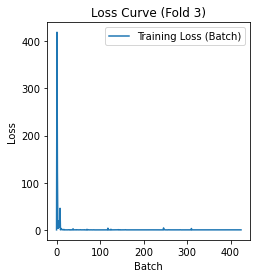

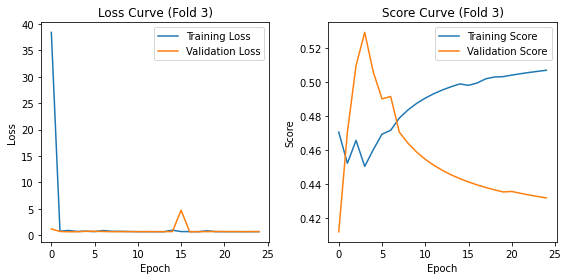

FOLD 4                                                                                  
--------------------------------                                                        
Epoch 1: Training loss = 37.870, Validation loss = 0.675                                
Epoch 2: Training loss = 0.900, Validation loss = 0.710                                 
Epoch 3: Training loss = 0.877, Validation loss = 0.687                                 
Epoch 4: Training loss = 0.817, Validation loss = 0.697                                 
Epoch 5: Training loss = 0.699, Validation loss = 0.706                                 
Epoch 6: Training loss = 0.697, Validation loss = 0.708                                 
Epoch 7: Training loss = 0.695, Validation loss = 0.692                                 
Epoch 8: Training loss = 0.697, Validation loss = 0.691                                 
Epoch 9: Training loss = 0.696, Validation loss = 0.688                                 
Epoch 10: Training lo

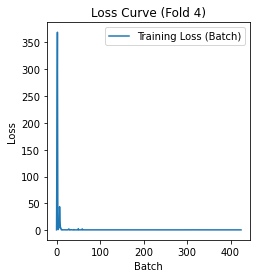

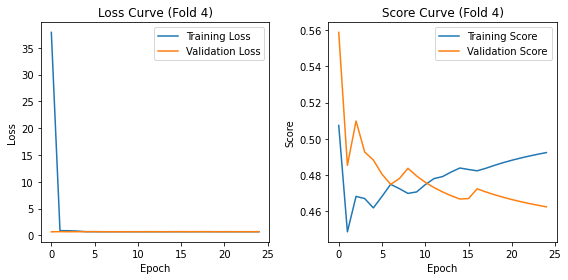

FOLD 5                                                                                  
--------------------------------                                                        
Epoch 1: Training loss = 27.994, Validation loss = 0.659                                
Epoch 2: Training loss = 1.527, Validation loss = 0.630                                 
Epoch 3: Training loss = 0.841, Validation loss = 0.709                                 
Epoch 4: Training loss = 0.940, Validation loss = 0.689                                 
Epoch 5: Training loss = 0.724, Validation loss = 0.683                                 
Epoch 6: Training loss = 0.683, Validation loss = 0.680                                 
Epoch 7: Training loss = 0.768, Validation loss = 0.708                                 
Epoch 8: Training loss = 0.718, Validation loss = 0.694                                 
Epoch 9: Training loss = 0.692, Validation loss = 0.700                                 
Epoch 10: Training lo

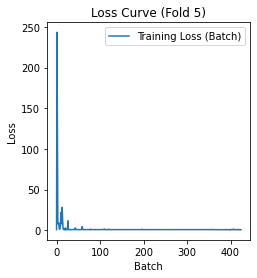

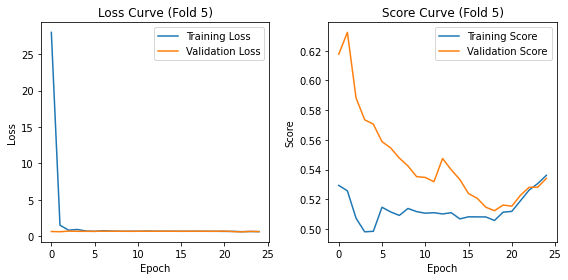

Accuracy for fold 5 = 53.412%                                                           

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS                                             
----------------------------------------------------                                    
Average Accuracy = 53.41%                                                               
100%|██████████| 10/10 [20:27:47<00:00, 7366.75s/trial, best loss: -85.70588235294117]  
Best hyperparameters:


{'dropout_rate': 0.4880700596575265,
 'lr': 0.00020762885639534018,
 'num_neurons_fc1': 512,
 'num_neurons_fc2': 1024,
 'optimizer': torch.optim.adam.Adam,
 'wd': 0.00044492001940255613}

In [8]:
from hyperopt import rand

# Define the optimization algorithm
algorithm = rand.suggest

# Define the number of iterations for optimization
max_evals = 10

# Initialize a trials object to store the optimization results
trials = Trials()

# Run HyperOpt optimization
best = fmin(objective, space=space, algo=algorithm, max_evals=max_evals, trials=trials)

# Print the best hyperparameters found
print("Best hyperparameters:")
space_eval(space, best)

## Hyperparameter search using Tree-structured Parzen Estimator (TPE)
Uses a model to estimate the probability of a configuration being better than another based on previous evaluations. It balances exploration and exploitation to efficiently search the space.

In [ ]:
# Define the optimization algorithm
algorithm = tpe.suggest

# Define the number of iterations for optimization
max_evals = 15

# Initialize a trials object to store the optimization results
trials = Trials()

# Run HyperOpt optimization
best = fmin(objective, space=space, algo=algorithm, max_evals=max_evals, trials=trials)

# Print the best hyperparameters found
print("Best hyperparameters:")
space_eval(space, best)

In [ ]:
model = ConvNeuralNet(dropout_rate=0.462, num_neurons_fc1=1024, num_neurons_fc2=256)
optimizer = optim.SGD(model.parameters(), lr=0.003643, weight_decay=0.000152)
criterion = nn.CrossEntropyLoss()

trained_model, loss_log, test_log = training_Kfold(model, num_epochs=30, data_set=data_set, 
                                                   kfold=kfold, criterion=criterion, optimizer=optimizer, 
                                                   batch_size=8, patience=10, save_model=True, savepath="CNN_model.pth")
test(trained_model, test_dataset, batch_size=8)